add validation, scoring

# load packages

In [1]:
import os
from skimage.data import imread
from skimage.morphology import label
import pandas as pd
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

input_dir = '../input/'
train_img_dir = '../input/train_v2/'
test_img_dir = '../input/test_v2/'

Using TensorFlow backend.


# load train_dataframe

In [2]:
train_df = pd.read_csv(input_dir+'train_ship_segmentations_v2.csv')

In [3]:
train_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [4]:
train_df.shape

(231723, 2)

# remove 100000 non-ship images

In [5]:
def area_isnull(x):
    if x == x:
        return 0
    else:
        return 1

In [6]:
train_df['isnan'] = train_df['EncodedPixels'].apply(area_isnull)

In [7]:
train_df['isnan'].value_counts()

1    150000
0     81723
Name: isnan, dtype: int64

In [8]:
train_df = train_df.sort_values('isnan', ascending=False)
train_df = train_df.iloc[100000:]

In [9]:
train_df['isnan'].value_counts()

0    81723
1    50000
Name: isnan, dtype: int64

# calculate ship area and group by ImageId

In [10]:
def rle_to_mask(rle_list, SHAPE):
    tmp_flat = np.zeros(SHAPE[0]*SHAPE[1])
    if len(rle_list) == 1:
        mask = np.reshape(tmp_flat, SHAPE).T
    else:
        strt = rle_list[::2]
        length = rle_list[1::2]
        for i,v in zip(strt,length):
            tmp_flat[(int(i)-1):(int(i)-1)+int(v)] = 255
        mask = np.reshape(tmp_flat, SHAPE).T
    return mask

In [11]:
def calc_area_for_rle(rle_str):
    rle_list = str(rle_str).split()
    mask = rle_to_mask(rle_list, (768,768))
    area = mask.sum()/255.0
    return area

In [12]:
train_df['area'] = train_df['EncodedPixels'].apply(calc_area_for_rle)

In [14]:
train_gp = train_df.groupby('ImageId').sum()
train_gp = train_gp.reset_index()

In [18]:
# There are images with the same ImageID
len(train_df),len(np.unique(train_df['ImageId']))

(131723, 92556)

In [15]:
train_gp.head()

,ImageId,isnan,area
0,000155de5.jpg,0,3388.0
1,000194a2d.jpg,0,1460.0
2,0001b1832.jpg,1,0.0
3,00021ddc3.jpg,0,1176.0
4,0002756f7.jpg,0,408.0


# set class of ship area

In [19]:
def calc_class(area):
    area = area / (768*768)
    if area == 0:
        return 0
    elif area < 0.005:
        return 1
    elif area < 0.015:
        return 2
    elif area < 0.025:
        return 3
    elif area < 0.035:
        return 4
    elif area < 0.045:
        return 5
    else:
        return 6

In [20]:
train_gp['class'] = train_gp['area'].apply(calc_class)

In [21]:
train_gp['class'].value_counts()

0    50000
1    29315
2     9225
3     2644
4     1122
5      181
6       69
Name: class, dtype: int64

# split train-set and validation-set (stratified: area class)

In [22]:
train, val = train_test_split(train_gp, test_size=0.01, stratify=train_gp['class'].tolist())

In [23]:
train_isship_list = train['ImageId'][train['isnan']==0].tolist()
train_isship_list = random.sample(train_isship_list, len(train_isship_list))
train_nanship_list = train['ImageId'][train['isnan']==1].tolist()
train_nanship_list = random.sample(train_nanship_list, len(train_nanship_list))

In [30]:
val_isship_list = val['ImageId'][val['isnan']==0].tolist()
val_isship_list = random.sample(val_isship_list, len(val_isship_list))
val_nanship_list = val['ImageId'][val['isnan']==1].tolist()
val_nanship_list = random.sample(val_nanship_list, len(val_nanship_list))

In [31]:
len(train_isship_list),len(train_nanship_list),len(val_nanship_list),len(val_nanship_list)

(42130, 49500, 500, 500)

# create data generator
Make the ratio of is-ship images and nan-ship images  equal

In [25]:
def mygenerator(isship_list, nanship_list, batch_size, cap_num):
    train_img_names_nanship = isship_list[:cap_num]
    train_img_names_isship = nanship_list[:cap_num]
    k = 0
    while True:
        batch_img_names_nan = train_img_names_nanship[k:k+batch_size//2]
        batch_img_names_is = train_img_names_isship[k:k+batch_size//2]
        batch_img = []
        batch_mask = []
        for name in batch_img_names_nan:
            tmp_img = imread(train_img_dir + name)
            tmp_img = np.mean(tmp_img, axis=2, keepdims=True)
            batch_img.append(tmp_img)
            mask_list = train_df['EncodedPixels'][train_df['ImageId'] == name].tolist()
            one_mask = np.zeros((768, 768, 1))
            for item in mask_list:
                rle_list = str(item).split()
                tmp_mask = rle_to_mask(rle_list, (768, 768))
                one_mask[:,:,0] += tmp_mask
            batch_mask.append(one_mask)
        for name in batch_img_names_is:
            tmp_img = imread(train_img_dir + name)
            tmp_img = np.mean(tmp_img, axis=2, keepdims=True)
            batch_img.append(tmp_img)
            mask_list = train_df['EncodedPixels'][train_df['ImageId'] == name].tolist()
            one_mask = np.zeros((768, 768, 1))
            for item in mask_list:
                rle_list = str(item).split()
                tmp_mask = rle_to_mask(rle_list, (768, 768))
                one_mask[:,:,0] += tmp_mask
            batch_mask.append(one_mask)
        img = np.stack(batch_img, axis=0)
        mask = np.stack(batch_mask, axis=0)
        img = img / 255.0
        mask = mask / 255.0
        k += batch_size//2
        yield img, mask

In [44]:
BATCH_SIZE = 4
CAP_NUM = min(len(train_isship_list),len(train_nanship_list))
CAP_NUM_VALID = min(len(val_isship_list),len(val_nanship_list))
datagen = mygenerator(train_isship_list, train_nanship_list, batch_size=BATCH_SIZE, cap_num=CAP_NUM)
valid_datagen = mygenerator(val_isship_list, val_nanship_list, batch_size=BATCH_SIZE, cap_num=CAP_NUM)


# set model

In [45]:
inputs = Input(shape=(768,768,1))
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.4)(conv1)
pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.4)(conv2)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.4)(conv3)
pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Dropout(0.4)(conv4)
pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
conv5 = BatchNormalization()(conv5)
upcv6 = UpSampling2D(size=(2,2))(conv5)
upcv6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv6)
upcv6 = BatchNormalization()(upcv6)
mrge6 = concatenate([conv4, upcv6], axis=3)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)
upcv7 = UpSampling2D(size=(2,2))(conv6)
upcv7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv7)
upcv7 = BatchNormalization()(upcv7)
mrge7 = concatenate([conv3, upcv7], axis=3)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)
upcv8 = UpSampling2D(size=(2,2))(conv7)
upcv8 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv8)
upcv8 = BatchNormalization()(upcv8)
mrge8 = concatenate([conv2, upcv8], axis=3)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)
upcv9 = UpSampling2D(size=(2,2))(conv8)
upcv9 = Conv2D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv9)
upcv9 = BatchNormalization()(upcv9)
mrge9 = concatenate([conv1, upcv9], axis=3)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)
conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
model = Model(inputs=inputs, outputs=conv10)

In [46]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 768, 768, 1)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 768, 768, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 768, 768, 16) 64          conv2d_47[0][0]                  
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 768, 768, 16) 2320        batch_normalization_45[0][0]     
__________________________________________________________________________________________________
batch_norm

In [47]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

# training

In [48]:
import keras
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [49]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []        
        self.fig = plt.figure()  
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses,label="validation loss")
        plt.legend()
        plt.title("loss vs epoch in train")
        plt.show();    
plot_losses = PlotLosses()

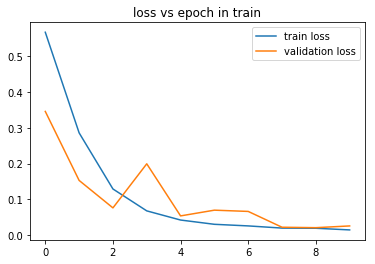

In [50]:
history = model.fit_generator(datagen, steps_per_epoch = 100, epochs = 10,validation_data=valid_datagen, \
                              validation_steps = 10,callbacks=[plot_losses])
plt.show()

# calculate F2 score for validation set

- set  function of caluculating  score

In [51]:
def calc_IoU(A, B):
    AorB = np.logical_or(A,B).astype('int')
    AandB = np.logical_and(A,B).astype('int')
    IoU = AandB.sum() / AorB.sum()
    return IoU

In [52]:
def calc_IoU_vector(A, B):
    score_vector = []
    IoU = calc_IoU(A, B)
    for threshold in np.arange(0.5,1,0.05):
        score = int(IoU > threshold)
        score_vector.append(score)
    return score_vector

In [53]:
def calc_IoU_tensor(masks_true, masks_pred):
    true_mask_num = masks_true.shape[0]
    pred_mask_num = masks_pred.shape[0]
    score_tensor = np.zeros((true_mask_num, pred_mask_num, 10))
    for true_i in range(true_mask_num):
        for pred_i in range(pred_mask_num):
            true_mask = masks_true[true_i]
            pred_mask = masks_pred[pred_i]
            score_vector = calc_IoU_vector(true_mask, pred_mask)
            score_tensor[true_i,pred_i,:] = score_vector
    return score_tensor

In [54]:
def calc_F2_per_one_threshold(score_matrix):
    tp = np.sum( score_matrix.sum(axis=1) > 0  )
    fp = np.sum( score_matrix.sum(axis=1) == 0 )
    fn = np.sum( score_matrix.sum(axis=0) == 0 )
    F2 = (5*tp) / ((5*tp) + fp + (4*fn))
    return F2

In [55]:
def calc_score_one_image(mask_true, mask_pred):
    mask_true = mask_true.reshape(768,768)
    mask_pred = mask_pred.reshape(768,768)
    if mask_true.sum() == 0 and mask_pred.sum() == 0:
        score = 1
    elif mask_true.sum() == 0 and mask_pred.sum() != 0:
        score = 0
    elif mask_true.sum() != 0 and mask_pred.sum() == 0:
        score = 0
    else:
        mask_label_true = label(mask_true)
        mask_label_pred = label(mask_pred)
        c_true = np.max(mask_label_true)
        c_pred = np.max(mask_label_pred)
        tmp = []
        for k in range(c_true):
            tmp.append(mask_label_true == k+1)
        masks_true = np.stack(tmp, axis=0)
        tmp = []
        for k in range(c_pred):
            tmp.append(mask_label_pred == k+1)
        masks_pred = np.stack(tmp, axis=0)
        score_tensor = calc_IoU_tensor(masks_true, masks_pred)
        F2_t = []
        for i in range(10):
            F2 = calc_F2_per_one_threshold(score_tensor[:,:,i])
            F2_t.append(F2)
        score = np.mean(F2_t)
    return score

In [56]:
def calc_score_all_image(batch_mask_true, batch_mask_pred, threshold=0.5):
    num = batch_mask_true.shape[0]
    tmp = batch_mask_pred > threshold
    batch_mask_pred = tmp.astype('int')
    scores = list()
    for i in range(num):
        score = calc_score_one_image(batch_mask_true[i], batch_mask_pred[i])
        scores.append(score)
    return np.mean(scores)

- set validation data

In [57]:
val_list = val['ImageId'].tolist()

In [58]:
def create_data(image_list):
    batch_img = []
    batch_mask = []
    for name in image_list:
        tmp_img = imread(train_img_dir + name)
        tmp_img = np.mean(tmp_img, axis=2, keepdims=True)
        batch_img.append(tmp_img)
        mask_list = train_df['EncodedPixels'][train_df['ImageId'] == name].tolist()
        one_mask = np.zeros((768, 768, 1))
        for item in mask_list:
            rle_list = str(item).split()
            tmp_mask = rle_to_mask(rle_list, (768, 768))
            one_mask[:,:,0] += tmp_mask
        batch_mask.append(one_mask)
    img = np.stack(batch_img, axis=0)
    mask = np.stack(batch_mask, axis=0)
    img = img / 255.0
    mask = mask / 255.0
    return img, mask

- put it together

In [59]:
from tqdm import tqdm

In [60]:
scores = []
for i in tqdm(range(len(val_list)//10)):
    temp_list = val_list[i*10:(i+1)*10]
    val_img, val_mask = create_data(temp_list)
    pred_mask = model.predict(val_img)
    F2 = calc_score_all_image(val_mask, pred_mask, threshold=0.5)*10
    scores.append(F2)
val_F2 = np.sum(scores)/(len(val_list)//10 *10)

100%|██████████| 92/92 [03:18<00:00,  2.42s/it]


In [61]:
for mask in val_mask:
    print(np.unique(mask))

[0.]
[0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0.]


In [73]:
pred_mask[8].reshape(768,768)

(10, 768, 768, 1)

In [70]:
np.unique(val_mask[8])

array([0., 1.])

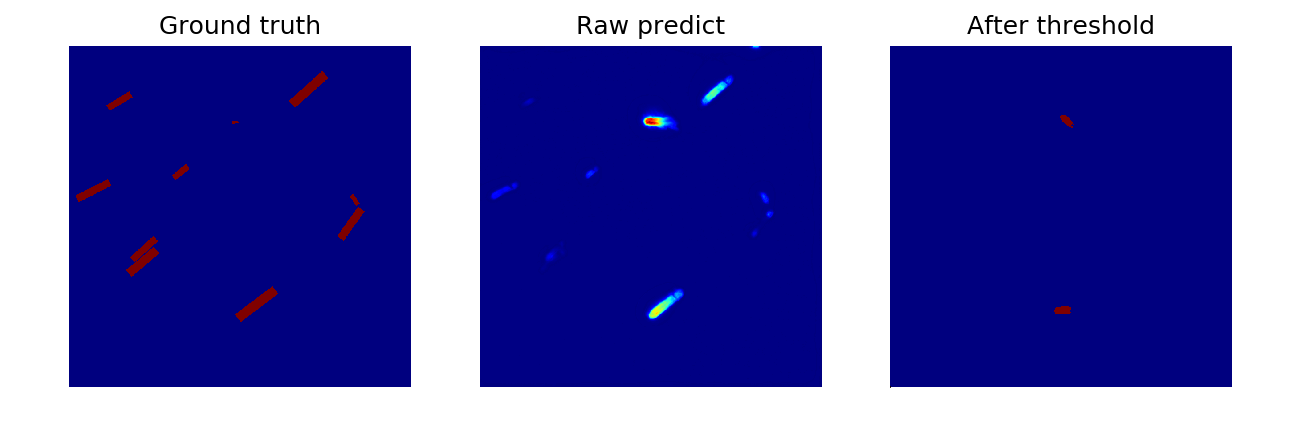

In [101]:
def plot_prediction(ax,img,name):
    im = ax.imshow(img.reshape(768,768), cmap='jet')
    ax.axis('off')
    ax.set_title(name)
    return im
figure = plt.figure(figsize=(10,30),dpi=150)
ax1 = figure.add_subplot(1,3,1)
im1 = plot_prediction(ax1, val_mask[8], "Ground truth")
ax2 = figure.add_subplot(1,3,2)
im2 = plot_prediction(ax2, pred_mask[8], "Raw predict")
ax3 = figure.add_subplot(1,3,3)
im3 = plot_prediction(ax3, (pred_mask[8]>0.4), "After threshold")
figure.colorbar(im2, cax=ax3)
plt.show()

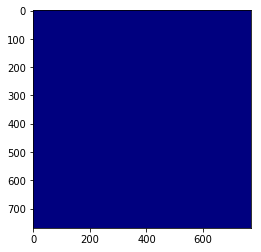

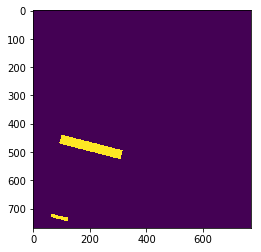

In [65]:
msk = pred_mask[2].reshape(768,768)
plt.figure()
plt.imshow(msk>0.5,cmap='jet')
plt.figure()
plt.imshow(val_mask[2].reshape(768,768))

In [66]:
val_F2

0.4819852498846222

# predict test set and submission

In [ ]:
test_img_names = [x.split('.')[0] for x in os.listdir(test_img_dir)]

In [ ]:
def mask_to_rle(mask):
    mask_flat = mask.flatten('F')
    flag = 0
    rle_list = list()
    for i in range(mask_flat.shape[0]):
        if flag == 0:
            if mask_flat[i] == 1:
                flag = 1
                starts = i+1
                rle_list.append(starts)
        else:
            if mask_flat[i] == 0:
                flag = 0
                ends = i
                rle_list.append(ends-starts+1)
    if flag == 1:
        ends = mask_flat.shape[0]
        rle_list.append(ends-starts+1)
    #sanity check
    if len(rle_list) % 2 != 0:
        print('NG')
    if len(rle_list) == 0:
        rle = np.nan
    else:
        rle = ' '.join(map(str,rle_list))
    return rle

In [ ]:
def multi_mask_to_rle(mask):
    masks = label(mask[0,:,:,0])
    return [mask_to_rle(masks==k) for k in np.unique(masks[masks>0])]

In [ ]:
pred_rows = []
for name in tqdm(test_img_names):
    test_img = imread(test_img_dir + name + '.jpg')
    test_img = np.mean(test_img, axis=2, keepdims=True)
    test_img = test_img.reshape(1,768,768,1)/255.0
    pred_prob = model.predict(test_img)
    pred_mask = pred_prob > 0.5
    rles = multi_mask_to_rle(pred_mask)
    if len(rles)>0:
        for rle in rles:
            pred_rows += [{'ImageId': name + '.jpg', 'EncodedPixels': rle}]
    else:
        pred_rows += [{'ImageId': name + '.jpg', 'EncodedPixels': None}]

In [ ]:
submission_df = pd.DataFrame(pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)